# Deep learning with EyeFeatures

While building custom models for complex tasks still requires a lot of effort, it would be a waste of time to reinvent the wheel and write a couple of hundreds raws of code to create convenient datasets and dataloaders, make sure that they couple with models and trainers and etc., then launch training CNNs, RNNs, etc. 
Training deep learning models typically requires more effort than using traditional machine learning algorithms and libraries like scikit-learn. However, deep learning models often deliver superior results. The EyeFeatures library simplifies this process for eye-tracking data by providing pre-built Datasets and models, implemented with torch and lightning. These are available in the `eyefeatures.deep.models` and `eyefeatures.deep.datasets` modules.

While building custom models for complex tasks still takes considerable effort, EyeFeatures saves time by eliminating the need to write extensive code for datasets, data loaders, and model-trainer integration, making it easier to train CNNs, RNNs, and other models.




# Datasets

To begin training deep learning models, we first need to choose the data representation to provide to the model later. For scanpath data, there are two main options: images or sequences (specifically, multi-dimensional time series). Images offer greater diversity but may lose some time-related information, while sequences retain the temporal structure of the data but are less variable in form.

The deep module provides `torch.utils.data.Dataset` classes (e.g. `Dataset2D`, `DatasetTimeSeries`) that implement `__len__` and `__getitem__`. You are responsible for splitting your data into train/validation/test sets; then you create one dataset per split, wrap them in `DataLoader`s, and pass the train and validation dataloaders directly to the PyTorch Lightning trainer. More on PyTorch datasets: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.

We begin by loading fixations data from the **data fixations** folder (you can find more about the data format in the `Preprocessing tutorial` and the dataset used in this tutorial at: https://zenodo.org/records/4655840). We then split the data ourselves, create datasets for each split, and build dataloaders.

Let's use the 2D dataset that creates heatmap and RGB scanpath graph arrays for every scanpath (more in `Complex representations tutorial`), stacking these representations along the channel dimension.

In [28]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from eyefeatures.deep.datasets import Dataset2D

data_dir = Path("../data/fixations/Paris_experiment_ready_data_fixations.csv")
data = pd.read_csv(data_dir)

X = data.drop(columns = ['TEXT_TYPE_label', 'TEXT_TYPE_2_label'])
Y = data[['group_subject', 'group_text', 'TEXT_TYPE_label']]

Y['TEXT_TYPE_label'] = Y['TEXT_TYPE_label'].map({'f': 0, 'a': 1, 'm': 2}).astype(int)

Y = Y.sample(200)
X = pd.merge(X, Y, on=['group_subject', 'group_text'])

# Split into train and validation (user-defined split). No Lightning DataModule — we pass dataloaders to the trainer.
pk = ['group_subject', 'group_text']
# One row per scanpath with labels for stratification
meta = Y.copy()
X_train_meta, X_val_meta, y_train, y_val = train_test_split(
    meta, meta['TEXT_TYPE_label'].values, test_size=0.5, stratify=meta['TEXT_TYPE_label'], random_state=42
)

X_train = pd.merge(X, X_train_meta[pk], on=pk)
X_val = pd.merge(X, X_val_meta[pk], on=pk)
Y_train = X_train_meta
Y_val = X_val_meta.copy()
Y_val['TEXT_TYPE_label'] = y_val

# Build datasets and dataloaders
batch_size = 8
shape = (16, 16)
representations = ['heatmap', 'baseline_visualization']

train_ds = Dataset2D(X_train, Y_train, x='norm_pos_x', y='norm_pos_y', pk=pk, shape=shape, representations=representations)
val_ds = Dataset2D(X_val, Y_val, x='norm_pos_x', y='norm_pos_y', pk=pk, shape=shape, representations=representations)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
val_loader = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

C:\Users\LEGION\AppData\Local\Temp\ipykernel_40344\1156610628.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['TEXT_TYPE_label'] = Y['TEXT_TYPE_label'].map({'f': 0, 'a': 1, 'm': 2}).astype(int)
100%|██████████| 95/95 [00:02<00:00, 34.29it/s]


(95, 3, 16, 16)
Number of channels = 4.


100%|██████████| 99/99 [00:02<00:00, 47.85it/s]

(99, 3, 16, 16)
Number of channels = 4.


# Creating model

Now we need to define CNN model which will process this 4 channel "images". We do not define separate model class for CNN in our library but we provide implemetation of some basic layers like VGG, ResNet etc and utility `make_simple_CNN`. This function takes dictionary with parameters for each layer and creates sequential Convolutional neural network model. 

In [29]:
from eyefeatures.deep.models import create_simple_CNN

CNN_model, output_shape = create_simple_CNN({
                    1:{'type':'VGG_block', 
                      'params':{'out_channels':10}},
                    2:{'type':'VGG_block', 
                      'params':{'out_channels':10}},
                    3:{'type':'Resnet_block', 
                      'params':{'out_channels':10}},
                    4:{'type':'Resnet_block', 
                      'params':{'out_channels':10}}
                      }, in_channels=4, shape=(16,16))

print(f"Output shape of our CNN will be {output_shape}")

100%|██████████| 4/4 [00:00<00:00, 3358.13it/s]

Output shape of our CNN will be (16, 16)


Now we need to wrap this model into classifier

In [30]:
from eyefeatures.deep.models import Classifier

CNN_classifier = Classifier(CNN_model, 
                   n_classes=len(Y['TEXT_TYPE_label'].unique()), 
                   classifier_hidden_layers=(25,) #add hidden layer with 25 neurons to classifier head
                   )

# Training
The only thing left is to create trainer and fit model which is just couple lines of code! We, also, will use the simplest logger provided by torch lightning - CSVLogger

In [31]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar
from tqdm import tqdm

logger = CSVLogger("Paris_exeperiment", name="CNN_model") #directory and subdirectory to store losses and metrics

class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True,)
        return bar

tr = pl.Trainer(logger = logger,
                max_epochs=100,
                log_every_n_steps=1,
                callbacks=[LitProgressBar()] #if You use Jupyter in VsCode, 
                )  #You may need this callback to supress redundant progress bars: https://lightning.ai/forums/t/progress-bar-in-jupyter-notebooks-visual-studio-code/4985/5

tr.fit(CNN_classifier, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | backbone        | Sequential          | 5.0 K  | train
1  | head            | ModuleList          | 0      | train
2  | loss_fn         | CrossEntropyLoss    | 0      | train
3  | flat            | Flatten             | 0      | train
4  | accuracy        | MulticlassAccuracy  | 0      | train
5  | precision       | MulticlassPrecision | 0      | train
6  | recall          | MulticlassRecall    | 0      | train
7  | f1              | MulticlassF1Score   | 0      | train
8  | macro_precision | MulticlassPrecision | 0      | train
9  | macro_recall    | MulticlassRecall    | 0      | train
10 | macro_f1        | MulticlassF1Score   | 0      | train
11 | prob            | Softmax             | 0      | train
------------------------------------------

c:\Users\LEGION\miniconda3\envs\eyefeatures-dev\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\LEGION\miniconda3\envs\eyefeatures-dev\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 12/12 [00:00<00:00, 77.82it/s, v_num=0, valid_loss=3.060, train_loss=0.000353] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 12/12 [00:00<00:00, 75.78it/s, v_num=0, valid_loss=3.060, train_loss=0.000353]


Now we can read results as simple csv table with pandas

# Getting results of training

In [32]:
metrics = pd.read_csv('Paris_exeperiment/CNN_model/version_0/metrics.csv')
metrics

,epoch,step,train_loss,val_acc_step,val_f1_class_0,val_f1_class_1,val_f1_class_2,val_macro_f1,val_macro_precision,val_macro_recall,val_precision_class_0,val_precision_class_1,val_precision_class_2,val_recall_class_0,val_recall_class_1,val_recall_class_2,valid_loss
0,0,11,NaN,0.333333,0.000000,0.460214,0.032323,0.190905,0.167869,0.343434,0.000000,0.329004,0.080808,0.000000,0.919192,0.020202,1.101839
1,0,11,1.276863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,23,NaN,0.333333,0.481260,0.000000,0.053872,0.188737,0.153199,0.326599,0.349928,0.000000,0.080808,0.905724,0.000000,0.040404,1.111470
3,1,23,1.102662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,35,NaN,0.353535,0.097162,0.482786,0.167003,0.259344,0.257015,0.345455,0.161616,0.378547,0.202020,0.070034,0.784512,0.148148,1.177009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,97,1175,0.000440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,98,1187,NaN,0.333333,0.284560,0.300914,0.289965,0.291813,0.344557,0.292256,0.329966,0.404040,0.299663,0.277441,0.269360,0.329966,3.068525
197,98,1187,0.000442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,99,1199,NaN,0.343434,0.289947,0.327850,0.284577,0.300791,0.349046,0.305724,0.336700,0.424242,0.286195,0.277441,0.309764,0.329966,3.064065


You can see NaNs. It happens due to internal operation of CSVLogger, which writes training and validation results to separate rows. For convenience we can split this dataframe to train loss Series and DataFrame with validation loss and metrics.

In [33]:
train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
val_loss_metrics = metrics.drop(columns='train_loss').dropna().reset_index(drop=True)

Now we can easily plot results

<Axes: >

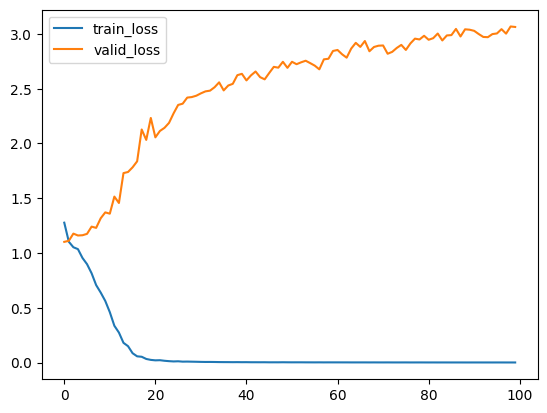

In [34]:
train_loss.plot(legend='train_loss')
val_loss_metrics['valid_loss'].plot(legend='valid_loss')

From the graph we can see that model overfits, which is expected result, because we supplied very little data to model. It important to remember that Neural Networks Usually require more data than classical ML algorithms.

# Training RNNs

In this section we will show how to train RNN model with Dataset for time series, which will present every sample as multidimensional time series [x position of fixation, y position of fixation, duration of fixation] and pad every batch.

In [35]:
from eyefeatures.deep.datasets import DatasetTimeSeries

# Use the same train/val split (X_train, X_val, Y_train, Y_val) from the first cell.
train_ds_ts = DatasetTimeSeries(
    X_train, Y_train, x='norm_pos_x', y='norm_pos_y', pk=pk,
    features=['duration'], max_length=10
)
val_ds_ts = DatasetTimeSeries(
    X_val, Y_val, x='norm_pos_x', y='norm_pos_y', pk=pk,
    features=['duration'], max_length=10
)
train_loader_ts = DataLoader(train_ds_ts, batch_size=batch_size, shuffle=True, collate_fn=train_ds_ts.collate_fn)
val_loader_ts = DataLoader(val_ds_ts, batch_size=batch_size, collate_fn=val_ds_ts.collate_fn)

100%|██████████| 99/99 [00:00<00:00, 7943.45it/s]


In [36]:
from eyefeatures.deep.models import SimpleRNN
#create simple RNN of LSTM type
RNN_model = SimpleRNN(
        rnn_type='LSTM', 
        input_size=3,  # x, y, duration (features=['duration'])
        hidden_size = 64, 
        num_layers=2, 
        bidirectional=False, 
        pre_rnn_linear_size=32
        ) 
#The next step is the same as for CNN model
RNN_classifier = Classifier(RNN_model, 
                   n_classes=len(Y['TEXT_TYPE_label'].unique()), 
                   classifier_hidden_layers=(25,), #add hidden layer with 25 neurons to classifier head
                   learning_rate = 0.01
                   )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | backbone        | SimpleRNN           | 58.5 K | train
1  | head            | ModuleList          | 0      | train
2  | loss_fn         | CrossEntropyLoss    | 0      | train
3  | flat            | Flatten             | 0      | train
4  | accuracy        | MulticlassAccuracy  | 0      | train
5  | precision       | MulticlassPrecision | 0      | train
6  | recall          | MulticlassRecall    | 0      | train
7  | f1              | MulticlassF1Score   | 0      | train
8  | macro_precision | MulticlassPrecision | 0      | train
9  | macro_recall    | MulticlassRecall    | 0      | train
10 | macro_f1        | MulticlassF1Score   | 0      | train
11 | prob            | Softmax             | 0      | train
------------------------------------------

c:\Users\LEGION\miniconda3\envs\eyefeatures-dev\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\LEGION\miniconda3\envs\eyefeatures-dev\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 12/12 [00:00<00:00, 75.52it/s, v_num=0, valid_loss=1.100, train_loss=1.100] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 12/12 [00:00<00:00, 72.83it/s, v_num=0, valid_loss=1.100, train_loss=1.100]


<Axes: >

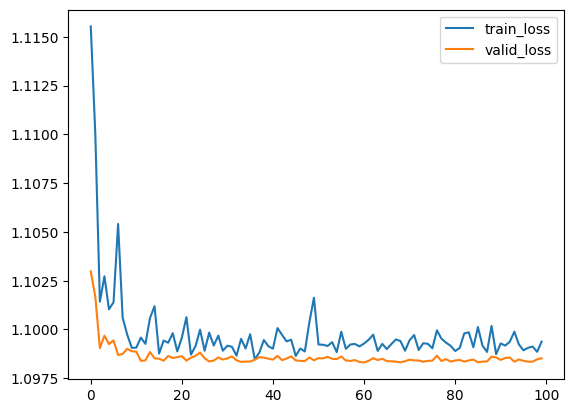

In [37]:
# same steps as before for CNN model
logger = CSVLogger("Paris_exeperiment", name="RNN_model") #directory and subdirectory to store losses and metrics

class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True,)
        return bar

tr = pl.Trainer(logger = logger,
                max_epochs=100,
                log_every_n_steps=1, 
                callbacks=[LitProgressBar()] #if You use Jupyter in VsCode, 
                )  #You may need this callback to supress redundant progress bars: https://lightning.ai/forums/t/progress-bar-in-jupyter-notebooks-visual-studio-code/4985/5

tr.fit(RNN_classifier, train_dataloaders=train_loader_ts, val_dataloaders=val_loader_ts)

metrics = pd.read_csv('Paris_exeperiment/RNN_model/version_0/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
val_loss_metrics = metrics.drop(columns='train_loss').dropna().reset_index(drop=True)

train_loss.plot(legend='train_loss')
val_loss_metrics['valid_loss'].plot(legend='valid_loss')

Situation is similar here - RNN need more data to learn something and differentiate between scanpaths, because network strugles to even overfit to training set.

# Combining CNN and RNN

We, also, can combine CNN and RNN as proposed in [Sims et al. 2020](https://dl.acm.org/doi/10.1145/3382507.3418828)

In [40]:
from eyefeatures.deep.datasets import TimeSeries_2D_Dataset
from eyefeatures.deep.models import VitNet

# Combine 2D and time-series datasets (same train/val split as above).
train_combined = TimeSeries_2D_Dataset(train_ds, train_ds_ts)
val_combined = TimeSeries_2D_Dataset(val_ds, val_ds_ts)
train_loader_2d_ts = DataLoader(train_combined, batch_size=batch_size, shuffle=True, collate_fn=train_combined.collate_fn)
val_loader_2d_ts = DataLoader(val_combined, batch_size=batch_size, collate_fn=val_combined.collate_fn)

VitNet_model = VitNet(
                 CNN_model, 
                 RNN_model, 
                 fusion_mode = 'concat', 
                 activation = None, 
                 embed_dim = 32)

VitNet_classifier = Classifier(VitNet_model, 
                   n_classes=len(Y['TEXT_TYPE_label'].unique()), 
                   classifier_hidden_layers=(25,), #add hidden layer with 25 neurons to classifier head
                   learning_rate = 0.01
                   )
